# Модуль предобработки BAMT

<p> Перед передачей данных на любой этап обучения BN пользователь должен очистить данные. Это можно сделать с помощью модуля предварительной обработки. <p>

## Импорт модулей и установка переменных системного пути

In [1]:
# Установка переменных пути
import os,sys
from pathlib import Path
currentdir = Path(os.getcwd())
sys.path.insert(0, os.path.dirname(currentdir.parent))
sys.path.insert(0, os.path.dirname(currentdir))
print(str(sys.path[0:3]))

['c:\\Users\\Worker1\\Documents\\BAMT', 'c:\\Users\\Worker1\\Documents', 'c:\\Users\\Worker1\\Documents\\BAMT\\MY']


In [2]:
%%time
import BAMT.Preprocessors as pp

import pandas as pd
import numpy as np
from sklearn import preprocessing

Wall time: 1.91 s


## Загрузить данные в память

*NB: Другой набор данных для экспериментов можно найти в папке Data. (N.B. - обратите внимание)*

In [3]:
hack = pd.read_csv(r'../Data/hack_processed_with_rf.csv')

In [4]:
hack.sample(10)

,Field name,Reservoir unit,Country,Region,Basin name,Tectonic regime,Latitude,Longitude,Operator company,Onshore/offshore,...,Period,Lithology,Gross,Netpay,Porosity,Permeability,Oil density,Oil recovery factor,Condensate recovery factor,Gas recovery factor
160,FORD-GERALDINE,BELL CANYON,USA,NORTH AMERICA,PERMIAN,COMPRESSION,31.9200,-104.0000,CONOCOPHILLIPS,ONSHORE,...,PERMIAN,SANDSTONE,14.1,7.5,21.0,18.0,825.072886,0.315,NaN,NaN
113,CUT BANK,CUT BANK SANDSTONE,USA,NORTH AMERICA,WESTERN CANADA,NaN,48.8208,-112.2007,MONTANA POWER COMPANY,ONSHORE,...,CRETACEOUS,SANDSTONE,14.1,4.8,NaN,110.0,834.808260,0.300,NaN,NaN
217,JUDY CREEK,SWAN HILLS (JUDY CREEK A POOL),CANADA,NORTH AMERICA,WESTERN CANADA,COMPRESSION,54.4995,-115.4904,IMPERIAL OIL RESOURCES,ONSHORE,...,DEVONIAN,LIMESTONE,69.0,18.0,9.0,45.0,820.289855,0.460,NaN,NaN
505,ZAKUM,THAMAMA ZONE III,UAE,MIDDLE EAST,RUB AL KHALI,GRAVITY,24.8667,53.6833,ADMA /ZADCO,OFFSHORE,...,CRETACEOUS,LIMESTONE,161.1,33.0,23.0,15.0,844.776119,0.320,NaN,NaN
487,YACHENG 13-1,LINGSHUI (LINGSHUI-3),CHINA,FAR EAST,QIONGDONGNAN,EXTENSION,17.5142,109.0088,CNOOC,OFFSHORE,...,PALEOGENE,SANDSTONE,205.8,92.4,12.7,281.0,825.072886,NaN,NaN,0.85
112,CUSIANA,MIRADOR,COLOMBIA,LATIN AMERICA,LLANOS,COMPRESSION,5.0299,-72.6719,BP AND OTHERS,ONSHORE,...,PALEOGENE,SANDSTONE,120.0,60.0,9.0,100.0,842.763550,0.600,NaN,0.80
164,FUYU,FUYU (QUANTOU),CHINA,FAR EAST,SONGLIAO,INVERSION,45.1999,124.8167,PETROCHINA,ONSHORE,...,CRETACEOUS,SANDSTONE,78.0,9.9,24.0,182.0,870.769231,0.330,NaN,NaN
447,VAREGAN,MEGION-VAREGAN (A5-B10),RUSSIA,FORMER SOVIET UNION,SIBERIAN WESTERN,COMPRESSION,62.6167,77.6622,NOYABRSKNEFTEGAS,ONSHORE,...,CRETACEOUS,SANDSTONE,945.0,128.7,23.6,187.0,815.561960,0.300,NaN,NaN
155,ETAME,GAMBA,GABON,AFRICA,GABON SOUTH,EXTENSION,-3.7656,10.5213,VAALCO,OFFSHORE,...,CRETACEOUS,SANDSTONE,14.1,10.8,30.0,1550.0,844.776119,0.400,NaN,NaN
276,MANSURI,ILAM,IRAN,MIDDLE EAST,ZAGROS,COMPRESSION,30.8833,48.8333,NIOC,ONSHORE,...,CRETACEOUS,CHALKY LIMESTONE,98.4,63.9,13.0,0.8,921.824104,0.080,NaN,NaN


In [5]:
hack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Field name                  514 non-null    object 
 1   Reservoir unit              514 non-null    object 
 2   Country                     514 non-null    object 
 3   Region                      514 non-null    object 
 4   Basin name                  514 non-null    object 
 5   Tectonic regime             442 non-null    object 
 6   Latitude                    514 non-null    float64
 7   Longitude                   514 non-null    float64
 8   Operator company            514 non-null    object 
 9   Onshore/offshore            514 non-null    object 
 10  Hydrocarbon type            514 non-null    object 
 11  Reservoir status            514 non-null    object 
 12  Structural setting          514 non-null    object 
 13  Depth                       514 non

<AxesSubplot:>

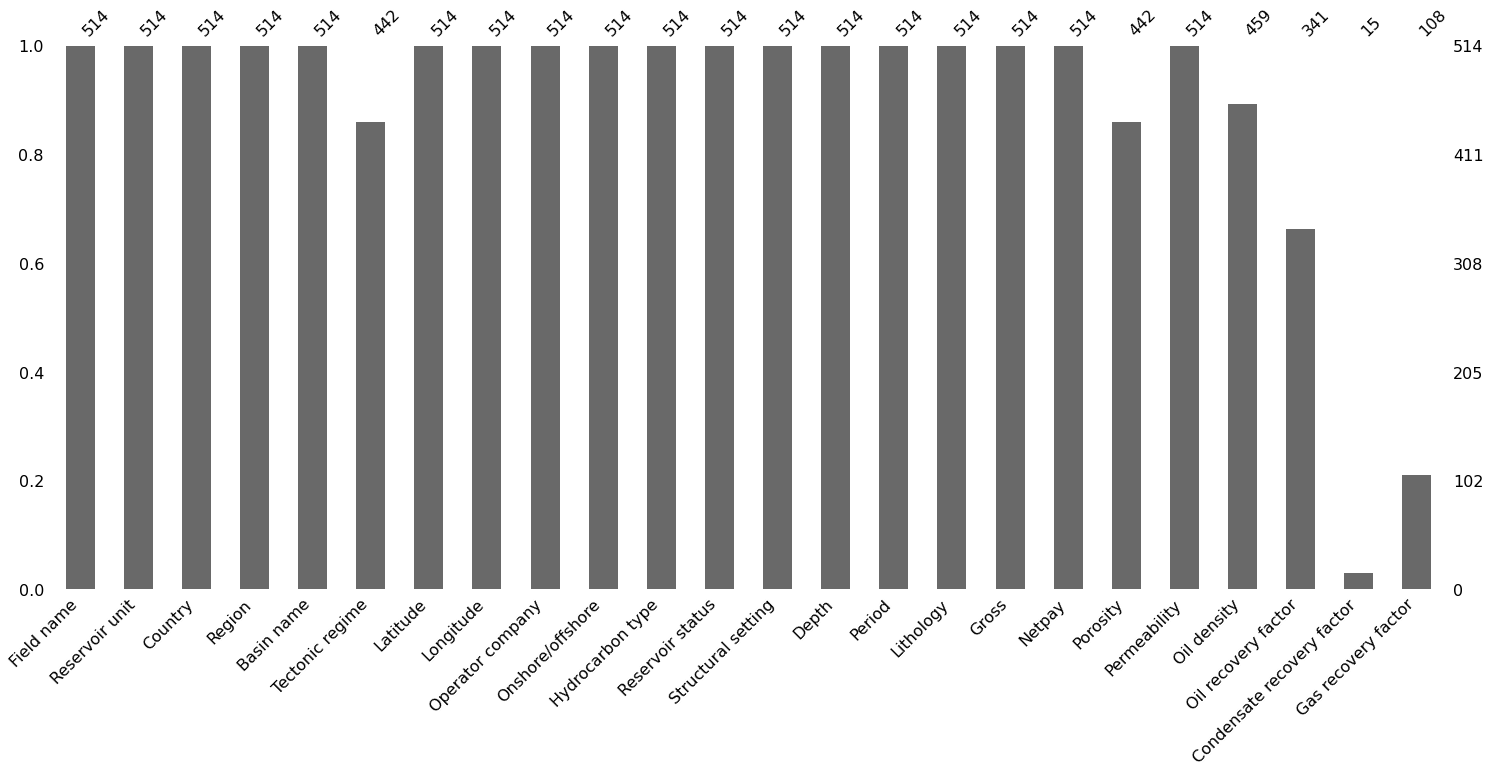

In [6]:
# NaN анализ
import missingno as msno
msno.bar(hack)

In [7]:
# Оставим информативные столбцы 
cols = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay','Porosity','Permeability', 'Depth']
hack = hack[cols]

## Создание/применение предобработчиков

<p> Чтобы применить предобработчик, пользователь должен предоставить pipeline: список с (имя объекта, объект).
    <br>Порядок важен! <br>
    Пользователь может передать пустой список, чтобы просто удалить na. <p>

In [8]:
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
discretized_data, est = p.apply(hack)

In [9]:
# посмотрим на случайную выборку из 5 наблюдений
discretized_data.sample(5)

,Tectonic regime,Period,Lithology,Structural setting,Gross,Netpay,Porosity,Permeability,Depth
274,0,9,11,2,0,0,1,3,2
173,0,13,11,10,3,3,0,2,4
204,2,7,10,5,0,1,3,2,2
393,2,12,9,3,0,1,1,1,2
421,2,17,11,6,3,4,1,3,4


In [11]:
# видим, что больше нет пропусков
discretized_data.isna().sum()

Tectonic regime       0
Period                0
Lithology             0
Structural setting    0
Gross                 0
Netpay                0
Porosity              0
Permeability          0
Depth                 0
dtype: int64

In [12]:
# попробуем никак не кодировать, в Preprocessor без кодирования
empty_p = pp.Preprocessor([])
empty_p_data, est_e = empty_p.apply(hack)

In [13]:
empty_p_data

,Tectonic regime,Period,Lithology,Structural setting,Gross,Netpay,Porosity,Permeability,Depth
0,COMPRESSION,JURASSIC,LIMESTONE,FORELAND,75.0,55.2,21.0,410.0,1815.0
1,EXTENSION,CRETACEOUS,SANDSTONE,RIFT,223.5,43.2,10.0,8.0,3084.6
2,STRIKE-SLIP,NEOGENE,THINLY-BEDDED SANDSTONE,WRENCH,34.5,19.8,22.0,200.0,2952.9
3,STRIKE-SLIP,NEOGENE,SANDSTONE,WRENCH,152.7,123.0,20.0,300.0,3149.7
4,COMPRESSION,CRETACEOUS,LIMESTONE,SALT,75.0,30.0,21.0,60.0,1486.5
...,...,...,...,...,...,...,...,...,...
437,EXTENSION,PALEOGENE,SANDSTONE,RIFT,69.0,20.7,26.7,1872.0,1615.2
438,EXTENSION,PALEOGENE,SANDSTONE,RIFT,49.2,18.6,23.2,121.0,1416.3
439,EXTENSION,MESOZOIC,VOLCANICS,RIFT,147.6,58.2,12.7,3.6,2952.9
440,COMPRESSION,CARBONIFEROUS,SANDSTONE,FORELAND,78.6,9.9,24.0,30.0,561.0


In [14]:
# видим, что нет пропусков и ничего не закодировано
discretized_data.isna().sum(), est_e

(Tectonic regime       0
 Period                0
 Lithology             0
 Structural setting    0
 Gross                 0
 Netpay                0
 Porosity              0
 Permeability          0
 Depth                 0
 dtype: int64,
 None)